In [12]:
from src.scratches.multi_agent_supervisor_1 import *
from src.scratches.multi_agent_supervisor_2 import *

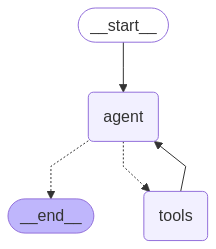

In [13]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

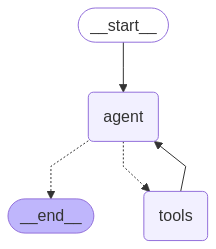

In [14]:
display(Image(graph2.get_graph().draw_mermaid_png()))

In [4]:
stream_graph_updates2("what is 2+2")

AI Message: 
  Tool: add
  Tool Args: {'a': 2, 'b': 2}
  Tool Message: 4.0
Tool Message: 4.0
AI Message: The result of \(2 + 2\) is \(4\).


'[\'AI Message: \', \'  Tool: add\', "  Tool Args: {\'a\': 2, \'b\': 2}", \'  Tool Message: 4.0\', \'Tool Message: 4.0\', \'AI Message: The result of \\\\(2 + 2\\\\) is \\\\(4\\\\).\']'

In [5]:
stream_graph_updates("what is 2 times 2")

AI Message: 
  Tool: multiply
  Tool Args: {'a': 2, 'b': 2}
  Tool Message: 4.0
Tool Message: 4.0
AI Message: 2 times 2 is 4.


'[\'AI Message: \', \'  Tool: multiply\', "  Tool Args: {\'a\': 2, \'b\': 2}", \'  Tool Message: 4.0\', \'Tool Message: 4.0\', \'AI Message: 2 times 2 is 4.\']'

In [15]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        # highlight-next-line
        return Command(
            # highlight-next-line
            goto=agent_name,  # (1)!
            # highlight-next-line
            update={**state, "messages": state["messages"] + [tool_message]},  # (2)!
            # highlight-next-line
            graph=Command.PARENT,  # (3)!
        )

    return handoff_tool

In [16]:
# Handoffs
assign_to_addition_agent = create_handoff_tool(
    agent_name="addition_agent",
    description="Assign task to a addition agent.",
)
assign_to_multiplier_agent = create_handoff_tool(
    agent_name="multiplier_agent",
    description="Assign task to a multiplication agent.",
)

In [8]:
from langgraph.prebuilt import create_react_agent
supervisor_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[assign_to_addition_agent, assign_to_multiplier_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- an addition agent. Assign math-related addition tasks to this agent\n"
        "- a multiplication agent. Assign math-related multiplication tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

In [18]:
from langgraph.graph import END

# Define the multi-agent supervisor graph
supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_agent, destinations=("addition_agent", "multiplier_agent", END))
    .add_node(addition_agent)
    .add_node(multiplier_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("addition_agent", "supervisor")
    .add_edge("multiplier_agent", "supervisor")
    .compile()
)

In [19]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)